In [7]:
from __future__ import absolute_import, print_function, unicode_literals
import sys
import os
import repackage
repackage.up()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import kde
import seaborn as sns
from matplotlib.pyplot import cm 
from importlib import reload

import analysis2 as a2
from IPython.display import display, HTML
sys.path.append('/home/janekg89/Develop/Pycharm_Projects/flutype_webapp')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "flutype_webapp.settings")
import django
django.setup()
from flutype.models import Spot
import preprocessing as pp


In [17]:
reload(pp)

<module 'preprocessing' from '/home/janek89/Dev/flutype_analysis_web/preprocessing.py'>

In [59]:
spots = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=["microarray_2018_03_21"])
spots_dj = spots.filter(spot_collection__sid = "quant1")

data_slides = a2.Data(spots_dj=spots_dj)

/home/janek89/Dev/flutype_analysis_web/analysis2.py:130: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Test", row)
/home/janek89/Dev/flutype_analysis_web/analysis2.py:131: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Train", tuple(set(cs) - set(row)))


In [60]:
#spots_norm = pp.lowless_norm(data_slides.spots_pd,"2018_03_21_slide_44")

In [61]:
import statsmodels.api as sm
from scipy.interpolate import interp1d

frames = []
master_collection = "2018_03_21_slide_43"
c1n = data_slides.spots_pd[data_slides.spots_pd["Collection"] == master_collection]
c1n_lf = c1n[c1n["Ligand"] == "LF"]

for name, spots_collection in data_slides.spots_pd.groupby(["Collection"]):
    if name == master_collection:
        continue
    sp_coll_lf = spots_collection[spots_collection["Ligand"] == "LF"]
    
    c2n_lf = sp_coll_lf.set_index(["Ligand Batch"])
    c2n = spots_collection.set_index(["Ligand Batch"])
    

    x1_lf = np.log10(c1n_lf["Intensity"].astype(float).values * c2n_lf["Intensity"]).astype(float).values
    x1 = np.log10(c1n["Intensity"].astype(float).values * c2n["Intensity"]).astype(float).values
    x1 = pd.DataFrame(x1, index=[c1n["Ligand Batch"]],columns = ["Intensity"])

    y1_lf = np.log2(c1n_lf["Intensity"].astype(float).values / c2n_lf["Intensity"].astype(float).values)
    lowess = sm.nonparametric.lowess(y1_lf, x1_lf, frac=0.33)
    f = interp1d(lowess[:, 0], lowess[:, 1], bounds_error=False)
    #hier comes the normlization
    x_mean = x1.groupby("Ligand Batch").agg(["mean", "std"])
    x_mean = x_mean.reset_index().rename(columns={"Intensity": "x_norm"})
    # x_norm is for normalization and is not used after normalization
    data = pd.merge(spots_collection, x_mean, how='left', left_on='Ligand Batch', right_on='Ligand Batch')
    data["Intensity"] = data["Intensity"].astype(float) * (2 ** (f(data[("x_norm", "mean")])))
    frames.append(data)
spots_new = pd.concat(frames)

/home/janek89/Envs/flutype_webapp/lib/python3.5/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
for name, spots_collection in data_slides.spots_pd.groupby(["Collection"]):
    if name == master_collection:
        continue
    sp_coll_lf = spots_collection[spots_collection["Ligand"] == "LF"]
    
    c2n_lf = sp_coll_lf.set_index(["Ligand Batch"])
    c2n = spots_collection.set_index(["Ligand Batch"])
    

    x1_lf = np.log10(c1n_lf["Intensity"].astype(float).values * c2n_lf["Intensity"]).astype(float).values
    x1 = np.log10(c1n["Intensity"].astype(float).values * c2n["Intensity"]).astype(float).values
    x1 = pd.DataFrame(x1, index=[c1n["Ligand Batch"]],columns = ["Intensity"])

    y1_lf = np.log2(c1n_lf["Intensity"].astype(float).values / c2n_lf["Intensity"].astype(float).values)
    lowess = sm.nonparametric.lowess(y1_lf, x1_lf, frac=0.33)
    f = interp1d(lowess[:, 0], lowess[:, 1], bounds_error=False)
    #hier comes the normlization
    x_mean = x1.groupby("Ligand Batch").agg(["mean", "std"])
    x_mean = x_mean.reset_index().rename(columns={"Intensity": "x_norm"})
    # x_norm is for normalization and is not used after normalization
    data = pd.merge(spots_collection, x_mean, how='left', left_on='Ligand Batch', right_on='Ligand Batch')
    data["Intensity"] = data["Intensity"].astype(float) * (2 ** (f(data[("x_norm", "mean")])))
    frames.append(data)
spots_new = pd.concat(frames)

In [62]:
spots_new = spots_new.dropna(how="all")
spots_new["Analyte Batch"] = "Unkown"

In [63]:
data_new = a2.Data(spots_pd=spots_new)

/home/janek89/Dev/flutype_analysis_web/analysis2.py:130: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Test", row)
/home/janek89/Dev/flutype_analysis_web/analysis2.py:131: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Train", tuple(set(cs) - set(row)))


In [64]:
data_final = data_new.outlier_filtering().sample_on_collection(20).clean()

/home/janek89/Envs/flutype_webapp/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/janek89/Dev/flutype_analysis_web/preprocessing.py:14: RuntimeWarning: invalid value encountered in greater
  return np.where(np.abs(modified_z_scores) > threshold)
/home/janek89/Dev/flutype_analysis_web/analysis2.py:130: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Test", row)
/home/janek89/Dev/flutype_analysis_web/analysis2.py:131: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Train", tuple(set(cs) - set(row)))


In [67]:
data1 = pd.DataFrame(data_final.x_pca_fit().transform(data_final.x)[:,:2],index=data_final.x.index , columns =["Principle 1", "Principle 2"])


In [70]:
def lda_plot(data, ax,contour=False, **kwargs):
    data.groupby("Collection")
    n = len(data1.groupby("Collection"))
    color=iter(cm.rainbow(np.linspace(0,1,n)))

    colors = ["r","g","b","k"]
    cmaps = ["Reds","Greens","Blues","Greys"]
              
    for n, d in data.groupby("Collection"):
        x = d["Principle 1"]
        y = d["Principle 2"]

        if contour:
            sns.kdeplot(x, y, label=n,ax=ax ,  c=next(color) , shade=True, shade_lowest=False,**kwargs )
            continue

        
        d.plot.scatter(x="Principle 1",y="Principle 2", ax=ax,    c=next(color), label=n,**kwargs)
from matplotlib.lines import Line2D


/home/janek89/Envs/flutype_webapp/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'c'
  s)


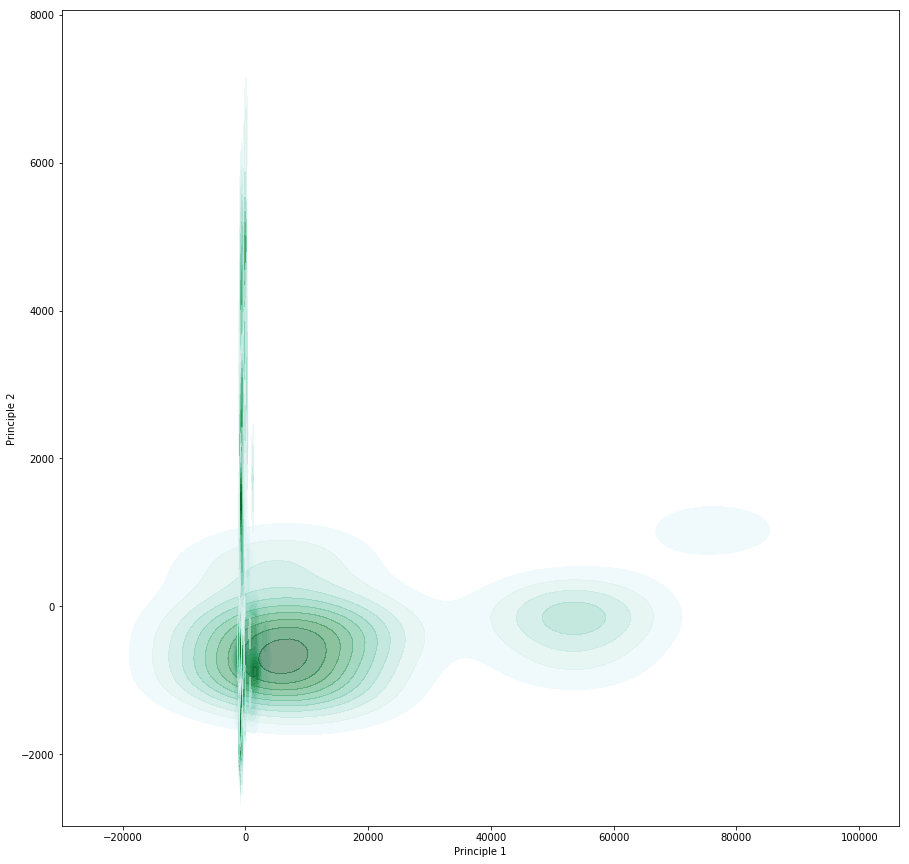

In [72]:
fig, ax = plt.subplots(figsize=(15,15))
#lda_plot(data_ldatrain,ax,contour=True,alpha=0.5)
#lda_plot(data_ldatest,ax,contour=True,alpha=0.5)
lda_plot(data1,contour=True, ax=ax,alpha=0.5)

#add_legend(ax)


#lda_plot(data1,ax,marker="x")

plt.show()

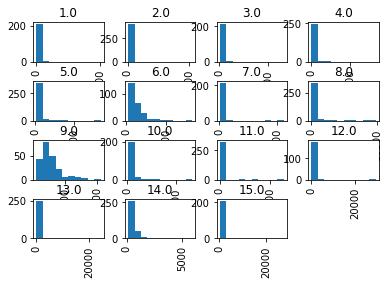

In [83]:
plt.show()

In [79]:
data_new = a2.Data(data_new.spots_pd[data_new.spots_pd["Ligand"] == "LF"])
data_new.outlier_filtering().spots_pd.hist(column="Intensity")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'values_list'

In [100]:
spots = Spot.objects.filter(raw_spot__raw_spot_collection__sid__in=["2018_03_21_slide_44"])
spots_dj = spots.filter(spot_collection__sid = "quant1")
data_slides = a2.Data(spots_dj=spots_dj)
print(len(data_slides.subset_ligand(["LF"]).spots_pd))


111


/home/janek89/Dev/flutype_analysis_web/analysis2.py:130: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Test", row)
/home/janek89/Dev/flutype_analysis_web/analysis2.py:131: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Train", tuple(set(cs) - set(row)))


In [102]:
data_new = data_slides.subset_ligand(["LF"])


/home/janek89/Dev/flutype_analysis_web/analysis2.py:130: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Test", row)
/home/janek89/Dev/flutype_analysis_web/analysis2.py:131: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  comb.set_value(i, "Train", tuple(set(cs) - set(row)))


111

/home/janek89/Envs/flutype_webapp/lib/python3.5/site-packages/pandas/plotting/_core.py:2166: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


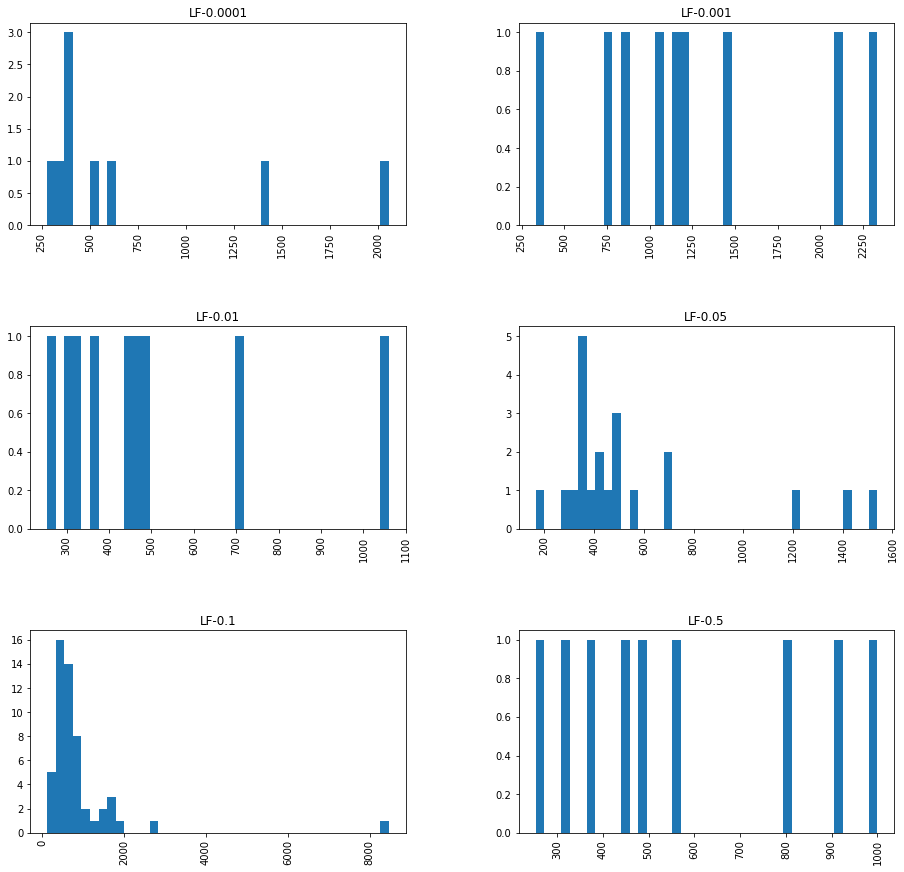

(None,)

In [112]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,15), sharex=True)

data_new.spots_pd.hist(column="Intensity",by="Ligand Batch" ,bins=40, ax=ax)
plt.show(),